<a href="https://colab.research.google.com/github/DeltSystem32/CIS3187-Assignment/blob/master/CIS3187_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Intelligence Coursework: Neural Network
## By Daniel Anthony Cilia 315499(M)
---



## Project Imports



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Prepare Data
 Read and parse data

Obtain testing and traning data from two CSV files in the project repository on Github.

The data consists of 5-bit numbers being mapped to 3-bit via the Boolean function ¬ABC.

Converters are used to map values to string upon import in order to retain all leading zeros.

#### Training set:

In [1057]:
data_url = "https://raw.githubusercontent.com/DeltSystem32/CIS3187-Assignment/master/full_dataset.csv?token=AIW66N4UA46SZD3JMZIWU7C6ERXXE"
df = pd.read_csv(data_url, converters={'input': lambda x: str(x), 'output': lambda x: str(x)})
df

,Num,input,output
0,1,00000,100
1,2,00001,100
2,3,00010,100
3,4,00011,100
4,5,00100,101
5,6,00101,101
6,7,00110,101
7,8,00111,101
8,9,01000,110
9,10,01001,110


#### Shuffle DataFrame rows

In [1058]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Num,input,output
0,15,01110,111
1,6,00101,101
2,3,00010,100
3,4,00011,100
4,19,10010,000
5,5,00100,101
6,29,11100,011
7,24,10111,001
8,11,01010,110
9,23,10110,001


#### Separate into trianing and testing datasets:

In [1059]:
training_df = df[:26]
training_df

,Num,input,output
0,15,01110,111
1,6,00101,101
2,3,00010,100
3,4,00011,100
4,19,10010,000
5,5,00100,101
6,29,11100,011
7,24,10111,001
8,11,01010,110
9,23,10110,001


#### Testing set:

In [1060]:
testing_df = df[26:]
testing_df

,Num,input,output
26,27,11010,010
27,21,10100,001
28,7,00110,101
29,20,10011,000
30,17,10000,000
31,32,11111,011


#### Size of data:

In [1061]:
print("Size of training set: " + str(len(training_df)))
print("Size of testing set: "+ str(len(testing_df)))

Size of training set: 26
Size of testing set: 6


## MLP Parameters

The Neural Network to be implemented will consist of the following:
*   **Number of input neurons**: 5
*   **Number of output neurons**: 3
*   **Number of hidden layers**: 1
*   **Number of hidden neurons**: 4
*   **Error threshold**: 0.2
*   **Learning rate**: 0.2
*   **Maximum number of epochs**: 999
*   **Transformation function**: Sigmoid

In [0]:
class parameters:
  NUM_IN_NEURONS = 5
  NUM_OUT_NEURONS = 3
  NUM_HIDDEN_LAYERS = 1
  NUM_HIDDEN_NEURONS = 4
  ERROR_THRESHOLD = 0.2
  LEARNING_RATE = 0.2
  MAX_EPOCHS = 999

### Sigmoid function implementation

The method will be called *transform()* so as to remain generic so that its body can be 'hotswapped' with other transformation functions if the need arises.

In [0]:
def transform(x):
  #sigmoid
  return 1 / (1 + np.exp(-x))
    

#add to MLP parameters
parameters.transform = transform

## MLP Class

### Initialisation

We will first begin by declaring the MLP's initialisation function. An array of 5-bit binary numbers is to be received:

In [0]:
class MLP:
  output = None
    
  def __init__(self):
    global wH, wO
    #hidden layer weights
    wH = self.generate_weights(parameters.NUM_IN_NEURONS,parameters.NUM_HIDDEN_NEURONS)
    #output layer weights
    wO = self.generate_weights(parameters.NUM_HIDDEN_NEURONS,parameters.NUM_OUT_NEURONS)

    print("Weights randomly generated.")
    print("Hidden weights:\n", wH)
    print("Output weights:\n", wO)

  def train(self, input_df):
    global wH, wO, epochs_list
    epoch = 1
    epochs_list = []

    print("------------------------------------------")
    while epoch <= parameters.MAX_EPOCHS:
      num_bad_facts = 0
      print("Epoch ", epoch)
      
      for index, fact in input_df.iterrows():
        input = np.array(list(fact["input"]),dtype=np.float64)
        target_output = np.array(list(fact["output"]),dtype=np.float64)

        result = self.feedforward(input, target_output)
        output, outH, error = result[0], result[1], result[2]

        is_good_fact = self.check_fact(error)

        if not is_good_fact:
          num_bad_facts += 1
          print("False")
          self.error_backpropagation(output, outH, target_output, input)
        else:
          print("True")

      epochs_list.append([epoch, ((num_bad_facts / len(input_df)) * 100)])
      epoch += 1
      print("------------------------------------------")

      if num_bad_facts == 0:
        print("Converged!!!!!!!!!!!!")
        break

        

  def test(self, input_df):
    for index, fact in input_df.iterrows():
      input = np.array(list(fact["input"]),dtype=np.float64)
      target_output = np.array(list(fact["output"]),dtype=np.float64)

      result = self.feedforward(input, target_output)
      output = result[0]
      error = result[2]
      print(input, "---------->", output)
      is_false = self.check_fact(error)
      print(bool(is_false), "! (Target: ",target_output,")")

      
  
  def plot(self):
    self.plot_epoch_graph(epochs_list)
        

To initialise the weights, we will need to do so randomly from -1 to 1. For this, a function is required to create a matrix of weights of any given size:

In [0]:
def generate_weights(self, columns, rows):
  return np.random.uniform(low=-1,high=1, size=(columns,rows))

#add to MLP
MLP.generate_weights = generate_weights

### Feed-forward

Function for applying the transformation function to all cells of a given array:

In [0]:
def transform_array(self, net):
  return [parameters.transform(j) for j in net]

# add to MLP
MLP.transform_array = transform_array

Loop through hidden layer and output layer, transforming input into MLP output. Matrix multiplication is performed using numpy's dot function:

In [0]:

def feedforward(self, input, target):
  netHArray = np.dot(input, wH).astype(np.float64) 
  outHArray = parameters.transform(netHArray) 
  netOArray = np.dot(outHArray, wO).astype(np.float64) 
  outOArray = parameters.transform(netOArray) 
  errorCount = np.array([0, 0, 0], dtype=np.float64) 

  # errorCount = target - outOArray
  i = 0 
  for output in outOArray: 
    errorCount[i] = np.absolute(np.subtract(target[i], output))
    # print(target[i], "- ", output , " = ", errorCount[i])
    i = i + 1 
  return outOArray, outHArray, errorCount

MLP.feedforward = feedforward

### Fact Checking

For each output of the MLP, compare with the expected output and produce the error difference: 

In [0]:
# def calculate_error(self, errors):
#   error_threshold = parameters.ERROR_THRESHOLD

#   print(errors)
#   for error in errors:
    
#     if np.absolute(error) > error_threshold: 
#       return False #bad fact

#   return True #good fact

# MLP.calculate_error = calculate_error

Given an array of errors, compare to error threshold and determine whether fact is good or bad:

In [0]:
def check_fact(self, errorCount):
  threshold = parameters.ERROR_THRESHOLD
  for error in errorCount: 
    if error > threshold: 
      return False 
  return True

MLP.check_fact = check_fact

### Error Backpropagation

Revise the weights of the MLP, beginning from the output layer. 

In [0]:
def error_backpropagation(self, outOArray, outHArray, target, initialInput):
  #output layer
  deltaOut = deltaOMethod(outOArray, target)
  newWeightOutput(deltaOut, outHArray)

  #hidden layer
  deltaHidden = deltaHMethod(deltaOut, outHArray)
  newWeightHidden(deltaHidden, initialInput)

MLP.error_backpropagation = error_backpropagation

Calculate the delta of each weight and total the weight difference. Return the new output weights and the delta values generated in the process.

In [0]:
def deltaOMethod(outO, target): 
  i = 0
  deltaO = np.array([0, 0, 0], dtype=np.float64)
  for entry in outO:
      deltaO[i] = entry * (1 - entry) * (target[i] - entry)
      i = i + 1
  return deltaO

def newWeightOutput(deltaList, outH): 
  eta = 0.2
  i = 0
  for output in outH:
      x = 0
      for delta in deltaList:
          wO[i][x] += eta * delta * output
          x = x + 1
      i = i + 1

MLP.deltaOMethod = deltaOMethod
MLP.newWeightOutput = newWeightOutput

Do the same for the weights of the hidden layer. This follows a more complicated process.

In [0]:
def deltaHMethod(deltaO, outH): 
  i = 0
  deltaH = np.array([0, 0, 0, 0], dtype=np.float64)
  for entry in outH:
      deltaH[i] = (entry * (1 - entry) * (sigmaDeltaO(deltaO, i)))
      i = i + 1
  return deltaH

def sigmaDeltaO(deltaO, index): 
  sum = 0
  x = 0
  for delta in deltaO:
    sum += (delta * wO[index, x])
    x = x + 1
  return sum

  return sum

def newWeightHidden(deltaList, initialInput): 
  eta = 0.2
  i = 0
  for input in initialInput:
      x = 0
      for delta in deltaList:
          wH[i][x] += eta * delta * input
          x = x + 1
      i = i + 1

MLP.deltaHMethod = deltaHMethod
MLP.sigmaDeltaO = sigmaDeltaO
MLP.newWeightHidden = newWeightHidden

## Graph Plotting

In [0]:
def plot_epoch_graph(self, epoch_list):
  epochs = np.array(epoch_list)

  for e in epoch_list:
    np.append(epochs, e)
  
  plt.plot(epochs[:,0], epochs[:,1])
  plt.xlabel('Epochs')
  plt.ylabel('% of Bad Facts')

  plt.title("Training Set")
  plt.show()

MLP.plot_epoch_graph = plot_epoch_graph

## Test Runner

In [1074]:
mlp = MLP()

Weights randomly generated.
Hidden weights:
 [[-0.1962492  -0.43923001  0.36434466  0.5712755 ]
 [-0.76716477  0.03292987 -0.66557533  0.16870065]
 [-0.24485284 -0.01211345 -0.34884575 -0.17593462]
 [ 0.7425285   0.63057078  0.64412432  0.79198579]
 [ 0.70684751  0.08884768  0.61716312 -0.85373093]]
Output weights:
 [[ 0.44536687 -0.65336686  0.47142551]
 [ 0.33788021  0.86901843  0.59260501]
 [-0.80411515  0.52584371  0.47771641]
 [-0.3323273  -0.18771853  0.86861186]]


In [1075]:
mlp.train(training_df)

------------------------------------------
Epoch  1
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  2
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  3
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  4
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  5
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

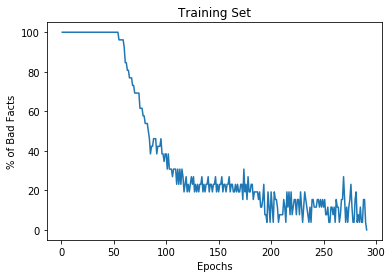

In [1076]:
mlp.plot()

In [1077]:
mlp.test(testing_df)

[1. 1. 0. 1. 0.] ----------> [0.0941299  0.82117881 0.09089207]
True ! (Target:  [0. 1. 0.] )
[1. 0. 1. 0. 0.] ----------> [0.12446924 0.23014871 0.8913031 ]
False ! (Target:  [0. 0. 1.] )
[0. 0. 1. 1. 0.] ----------> [0.8599001  0.05454037 0.88587113]
True ! (Target:  [1. 0. 1.] )
[1. 0. 0. 1. 1.] ----------> [0.05938781 0.10585992 0.10116607]
True ! (Target:  [0. 0. 0.] )
[1. 0. 0. 0. 0.] ----------> [0.02850091 0.31394341 0.15969786]
False ! (Target:  [0. 0. 0.] )
[1. 1. 1. 1. 1.] ----------> [0.16615851 0.79488999 0.8131204 ]
False ! (Target:  [0. 1. 1.] )
